In [1]:
import pandas as pd
import csv
import numpy as np
from math import sqrt
from sklearn.feature_extraction.text import CountVectorizer
countVector = CountVectorizer(min_df=1)

In [2]:
with open('./ml-20m/shuffledratings.csv') as movief:
    reader = csv.reader(movief)
    largemovielist = list(reader)
      
movieratingdf = pd.DataFrame(largemovielist, columns = ['userid','movieid','rating','time'])
movieratingdf[0:5]

,userid,movieid,rating,time
0,50286,2710,1.0,1070231811
1,108170,2324,4.5,1111820093
2,55219,436,3.0,946372124
3,19590,5316,5.0,1421784683
4,130580,3208,1.0,947895307


movieratingdf = movieratingdf.drop('time',axis=1)

In [5]:
movieratingdf['rating'] = movieratingdf['rating'].apply(lambda x:float(x))

movieratingdf['userid'] = movieratingdf['userid'].apply(lambda x:int(x))
movieratingdf['movieid'] = movieratingdf['movieid'].apply(lambda x:int(x))
globalAverage = float(sum(movieratingdf['rating']))/len(movieratingdf['rating'])


In [5]:
print globalAverage

3.5255285643


In [6]:
test1df = movieratingdf.tail(2000263)
train1df = movieratingdf.head(18000000)

In [7]:
test1df = test1df.reset_index()

In [8]:
usersize=movieratingdf['userid'].max(skipna=False)
itemsize=movieratingdf['movieid'].max(skipna=False)
minuser = movieratingdf['userid'].min(skipna=False)
minitem = movieratingdf['movieid'].min(skipna=False)
print usersize,itemsize,minuser,minitem

138493 131262 1 1


In [9]:
#adding 1 since the indexes for movies and users start from 1
#When we recommend we wont consider bias of 0 and pu and pq of 0
k=10
bu = np.random.rand(usersize+1)
bi = np.random.rand(itemsize+1)
pu = np.random.rand(usersize+1,k)
qi = np.random.rand(itemsize+1,k)
lamda = 0.02
learningrate = 0.02
errorlist = []
print pu.shape
print qi.shape
qi = qi.T
print qi.shape
print bu[0:5]
print bi[0:5]
print pu[0,:]
print qi[:,0]

(138494, 10)
(131263, 10)
(10, 131263)
[ 0.36455917  0.0472391   0.9855845   0.9006411   0.42788473]
[ 0.0016125   0.31885726  0.62776488  0.45535077  0.4355597 ]
[ 0.71126206  0.87521804  0.95521402  0.04970854  0.71587022  0.25963511
  0.13270262  0.23573297  0.47390155  0.84431391]
[ 0.67207045  0.17789316  0.80830351  0.57208468  0.40208603  0.56979037
  0.66602248  0.633882    0.74351331  0.43576283]


The below code is used to learn the bias without matrix factorisation. The final results have been obtained with matrix factorisation

In [ ]:
learningrate = 0.01
for i in range(1):
    errorlist = []
    for i in range(len(train1df)):
        userid = train1df['userid'][i]
        movieid = train1df['movieid'][i]
        error = train1df['rating'][i]-(globalAverage+bu[userid]+bi[movieid])#+np.dot(pu[userid,:],qi[:,itemid])
        bu[userid]=bu[userid]+(learningrate*(error-(lamda*bu[userid])))
        bi[movieid]=bi[movieid]+(learningrate*(error-(lamda*bi[movieid])))
        #qcol = qi[:,itemid]+(learningrate*(error*pu[userid,:]-lamda*qi[:,itemid]))
        #prow = pu[userid,:]+(learningrate*(error*qi[:,itemid]-lamda*pu[userid,:]))
        #qi[:,itemid]=qcol
        #pu[userid,:]=prow
        errorlist.append(error)

In [21]:
learningrate = 0.02
for i in range(1):
    errorlist = []
    for i in range(len(train1df)):
        userid = train1df['userid'][i]
        movieid = train1df['movieid'][i]
        error = train1df['rating'][i]-(globalAverage+bu[userid]+bi[movieid]+np.dot(pu[userid,:],qi[:,movieid]))
        bu[userid]=bu[userid]+(learningrate*(error-(lamda*bu[userid])))
        bi[movieid]=bi[movieid]+(learningrate*(error-(lamda*bi[movieid])))
        qcol = qi[:,movieid]+(learningrate*(error*pu[userid,:]-lamda*qi[:,movieid]))
        prow = pu[userid,:]+(learningrate*(error*qi[:,movieid]-lamda*pu[userid,:]))
        qi[:,movieid]=qcol
        pu[userid,:]=prow
        errorlist.append(error)

The below code is used to plot the error of stochastic gradient descent. The error has been average over 20 million values

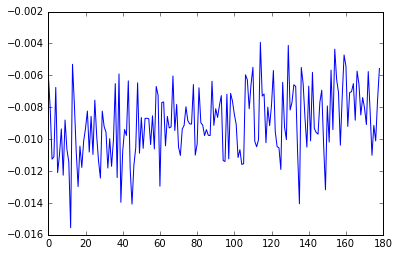

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
initial = 0
averageerror = []
for i in range(1,180):
    final = i*100000
    average = sum(errorlist[initial:final])/100000
    averageerror.append(average)
    initial = final
plt.plot(averageerror)
plt.show()


In [15]:
def getRMSE(df):
    df['error']=(df['prediction']-df['rating'])
    df['error']=df['error'].apply(lambda x:x*x)
    RMSE = sqrt((sum(df['error']))/float(len(df)))
    print RMSE

In [16]:
train1userid = train1df['userid'].unique()
train1movieid = train1df['movieid'].unique()

In [32]:
def getPrediction(test_df):
    ratinglist = []
    for i in range(len(test_df)):
        userid = test_df['userid'][i]
        itemid = test_df['movieid'][i]
        if userid in train1userid and itemid in train1movieid:
            rating = globalAverage+bu[userid]+bi[itemid]#+np.dot(pu[userIdDict[userid],:],qi[:,itemIdDict[itemid]])
        elif itemid in train1movieid:
            rating = globalAverage+bi[itemid]
        elif userid in train1userid:
            rating = globalAverage+bu[userid]
        else:
            rating = globalAverage
        ratinglist.append(rating)
    test_df['prediction'] = ratinglist
    return test_df['prediction']

In [17]:
#Get prediction with matrix factorisation
def getPrediction_with_matrix(test_df):
    ratinglist = []
    for i in range(len(test_df)):
        userid = test_df['userid'][i]
        itemid = test_df['movieid'][i]
        if userid in train1userid and itemid in train1movieid:
            rating = globalAverage+bu[userid]+bi[itemid]+np.dot(pu[userid,:],qi[:,itemid])
        elif itemid in train1movieid:
            rating = globalAverage+bi[itemid]
        elif userid in train1userid:
            rating = globalAverage+bu[userid]
        else:
            rating = globalAverage
        ratinglist.append(rating)
    test_df['prediction'] = ratinglist
    return test_df['prediction']

In [49]:
test1df['prediction'] = getPrediction(test1df)

In [23]:
test1df['prediction'] = getPrediction_with_matrix(test1df)

In [ ]:
test1df[1:100]

In [24]:
RMSE = getRMSE(test1df)

0.86595408744


On 20 M data:
1)   learning rate = 0.02 lambda = 0.1 RMSE = 0.87195 n = 1
2)   learning rate = 0.02 lambda = 0.01 RMSE = 0.866
3)  learning rate = 0.02 lambda = 0.01 RMSE = 0.8653 n = 3

With Matrix Factorisation:
4) learning rate = 0.02 lambda = 0.02 RMSE = 0.8748 n = 1
5) learning rate = 0.02 lambda = 0.01 RMSE = 0.845 n = 1
6) learning rate = 0.02 lambda = 0.01 RMSE = 0.01